# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [29]:
# import other stuff that we'll need

import numpy as np
import cv2
import tensorflow as tf
from random import shuffle
import time
from matplotlib import pyplot as plt
import csv
from collections import Counter, OrderedDict
import pandas as pd
from sklearn.model_selection import train_test_split

In [30]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [31]:
### To start off let's do a basic data summary.

n_train = len(train['features'])
n_test = len(test['features'])
image_shape = train['features'][0].shape
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [32]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Some helper stuff

# Get signnames.csv and put it into a dict
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile, delimiter=',')
    labels_dict = {rows[0]:rows[1] for rows in reader}

# Takes in a numerical label and returns the right text string
def get_text(num_label):
    return labels_dict[str(num_label)]

# Create another np ndarray of the text labels instead
# 'dtype = object' allows the np.ndarray to take in strings
text_labels = np.ndarray(len(train['labels']), dtype=object)
for i in range(0, len(train['labels'])):
    text_labels[i] = get_text(train['labels'][i])

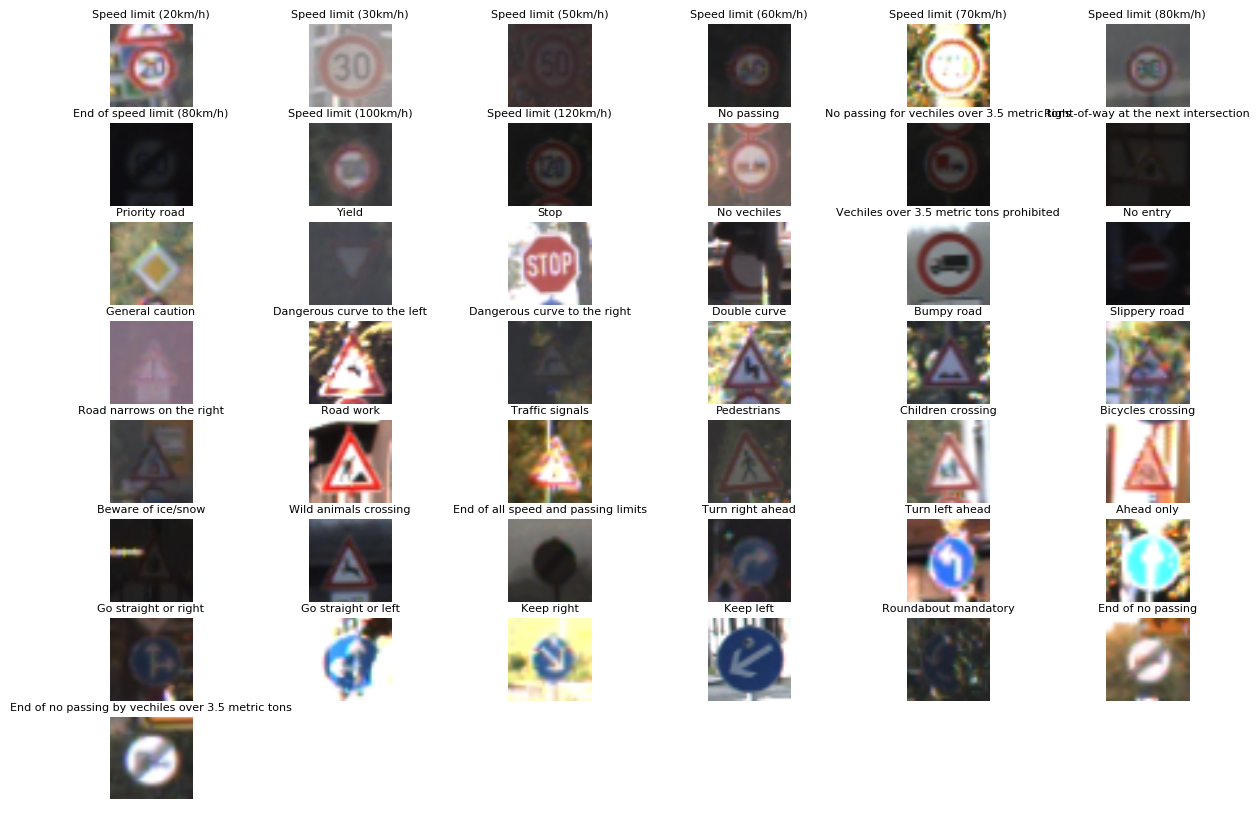

In [33]:
# Plot an example of each type of image

# Plot an example of each type
def plot_all(features, labels):
    displayed = []
    index = 0
    plot_num = 1

    plt.figure(figsize=(15, 10))
    for item in labels:
        if item not in displayed:
            plt.subplot(8, 6, plot_num)
            plt.imshow(features[index], cmap='gray')
            plt.title(get_text(labels[index]), fontsize=8)
            plt.axis('off')
            displayed.append(item)
            plot_num += 1
        index += 1
    plt.show()

plot_all(train['features'], train['labels'])

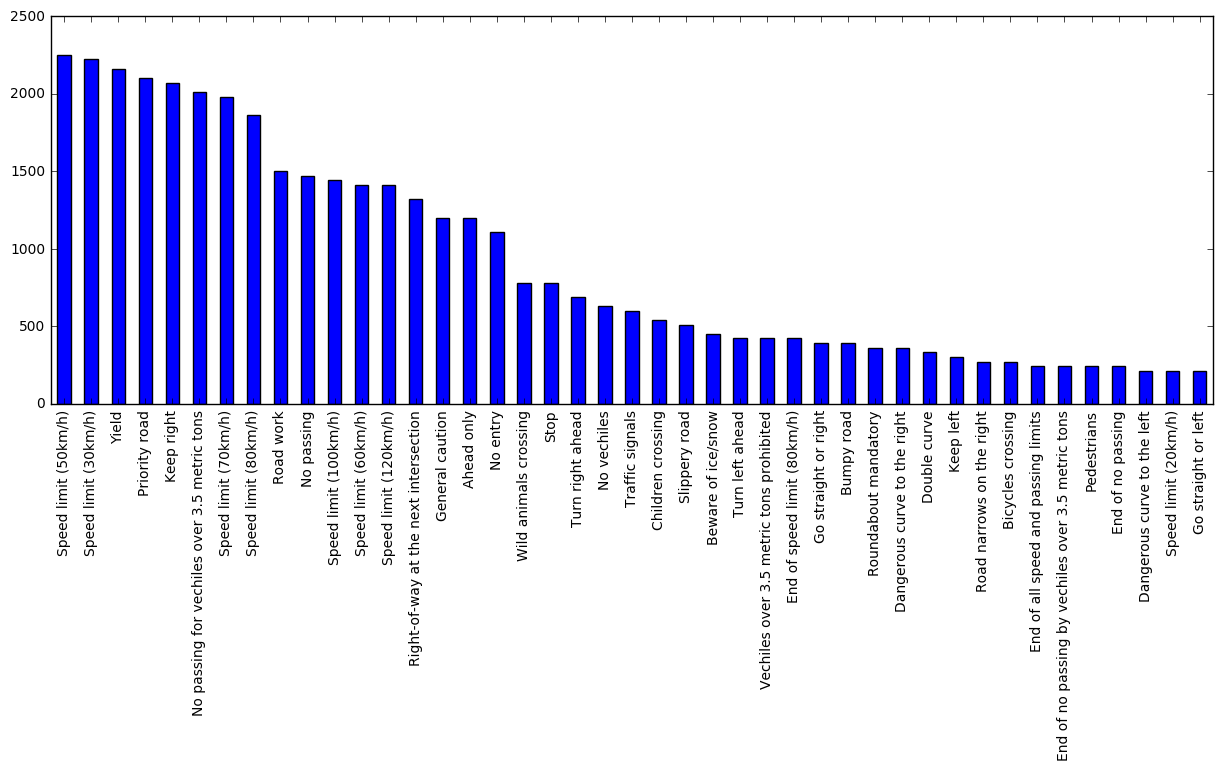

In [34]:
# Plot a histogram of the labels

# Plot a histogram of the labels
def plot_hist(labels):
    label_counts = Counter(labels)
    ordered_counts = OrderedDict(label_counts.most_common())
    df = pd.DataFrame.from_dict(ordered_counts, orient='index')
    df.plot(kind='bar', legend=None, figsize=(15,5))
    plt.show()

plot_hist(text_labels)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [35]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

## Helper function: convert an np.ndarray image from RGB to grayscale using OpenCV
def rgb_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Color to RGB
grey_train = {}
grey_train['features'] = []
for i in range(len(X_train)):
    grey_train['features'].append(rgb_to_gray(X_train[i]))
train['features'] = grey_train['features']

grey_test = {}
grey_test['features'] = []
for i in range(len(X_test)):
    grey_test['features'].append(rgb_to_gray(X_test[i]))
test['features'] = grey_test['features']


## Normalize: scale from 0 to 1
def normalize(image_list):
    normalized_train = {}
    normalized_train['features'] = []
    for i in range(len(image_list)):
        normalized_train['features'].append((image_list[i]) / 256)
    return normalized_train['features']

normalized_train = {}
normalized_train['features'] = normalize(train['features'])
train['features'] = normalized_train['features']

normalized_test = {}
normalized_test['features'] = normalize(test['features'])
test['features'] = normalized_test['features']

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Data was converted to greyscale using the BGR2RAY function of OpenCV, as the linked paper from the homework assignment page indicates that converting to grayscale improved accuracy.

Data was then normalized by taking the resulting value between 0 to 255 and normalizing to a value between 1 and -1, using 128 as the midpoint. 

I noticed that normalization from 0-255 to (-1, 1) made a huge difference in terms of accuracy, as the training accuracy never rose about 50% when the data was not normalized - I guess the drives the point home about stabilization issues with large numbers in Python.

Further changing normalization to value / 256 yielded even higher accuracies, driving home the point about the instability of large numbers.

In [36]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Parameters
learning_rate = 0.001
iterations = 8000
train_batch_size = 50
test_batch_size = 50
display_step = 10

# Split test data into half validation, half testing
# True "testing" data now lives in a dict called test2
validation = {}
test2 = {}
validation['features'], \
test2['features'], \
validation['labels'], \
test2['labels'] = train_test_split(test['features'], test['labels'], test_size=0.5)

# Stolen helper function for one_hot encoding
# lives in tensorflow.contrib.learn.python.learn.datasets.mnist
def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

one_hot_train_labels = dense_to_one_hot(train['labels'], n_classes)
one_hot_val_labels = dense_to_one_hot(validation['labels'], n_classes)
one_hot_test_labels = dense_to_one_hot(test2['labels'], n_classes)


# Shuffle training set
index = list(range(0, len(train['features']) - 1))
shuffle(index)

shuffled_features = []
shuffled_labels = []
for i in index:
    shuffled_features.append(train['features'][i])
    shuffled_labels.append(one_hot_train_labels[i])

# Create batches
total_batch = int(n_train / train_batch_size) + 1
feature_batches = np.array_split(shuffled_features, total_batch)
label_batches = np.array_split(shuffled_labels, total_batch)

n_input = image_shape[0] * image_shape[1]  # traffic sign input (img shape: 32*32)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** Used sklearn train_test split to split the testing set into half validation and half testing.
Will use validation data to test out different hyperparameters and architectures.

I also borrowed the dense_to_onehot function from the MNIST example, as I noticed that much of the preprocessing for the MNIST example was done in tensorflow.contrib.learn.python.learn.datasets.mnist.

The training data also gets shuffled; I noticed that the original set is ordered by label, so it obviously doesn't make sense to feed in the ordered set for training as each batch would then contain only one or two classes of sign.

In [37]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


# The actual CNN itself

# Define some helper functions for creating new variables
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


def new_biases(length):
    return tf.Variable(tf.constant(0.0, shape=[length]))


def new_conv_layer(input,               # Previous layer
                   num_input_channels,  # Num channels from previous layer
                   filter_size,         # Width x height of each filter, if 5x5 enter 5 here
                   num_filters,         # Number of filters
                   use_pooling=True,    # Use 2x2 max pooling or not
                   use_dropout=True):   # Use dropout?

    # shape determined by Tensorflow API
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create some new weights for the shape above and initialize them randomly
    weights = new_weights(shape=shape)

    # Create one bias for each filter
    biases = new_biases(length=num_filters)

    # Create Tensorflow convolution operation
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],  # first and last stride must always be 1
                         padding='SAME')        # padding: what to do at edge of image

    # Add biases to the reuslts of convolution:
    layer += biases

    # Use pooling if indicated:
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1, 2, 2, 1],
                              strides=[1,2,2,1],
                              padding='SAME')

    # Then use a RELU to introduce some non-linearity
    layer = tf.nn.relu(layer)

    # ReLU is normally executed before pooling
    # but relu(max_pool(x)) == max_pool(relu(x))
    # So would rather run ReLU on a smaller piece (1x1 as opposed to 2x2)

    # Use Dropout?
    if use_dropout:
        layer = tf.nn.dropout(layer, keep_prob)

    # return both layer and filter weights for later use when running the session
    return layer, weights


# Helper function to flatten a layer, i.e. when feeding form a conv layer into a fully connected
def flatten_layer(layer):
    # Get shape of input
    input_shape = layer.get_shape()

    # format of shape should be [num_images, img_height, img_width, num_channels]
    # total # of features is therefore img_height * img_width * num_channels; grab this
    num_features = input_shape[1:4].num_elements()

    # flatten to 2D, leaving the first dimension open
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features


# Helper function to make a fully connected layer
def new_fc_layer(input,             # previous layer
                 num_inputs,        # number of inputs from previous layer
                 num_outputs,       # of outputs
                 use_relu=True,     # Use ReLU?
                 use_dropout=True): # Use dropout?

    # Create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Layer is matrix mult of inputs by weights, plus bias
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    # Use Dropout?
    if use_dropout:
        layer = tf.nn.dropout(layer, keep_prob)

    return layer

# Layer configurations
# -------------------------
# Conv layer 1
filter_size1 = 3
num_filters1 = 36

# Conv layer 2
filter_size2 = 3
num_filters2 = 30

# Conv layer 3
filter_size3 = 3
num_filters3 = 24

# Fully connected layer 1
fc_size1 = 128

# Fully connected layer 2
fc_size2 = 64

# ------------------
# Get some image dimensions
img_size = image_shape[0]
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1        # Grayscale so only one channel
num_classes = n_classes

# tf Graph input
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')
# convert from one-hot to the class number
y_true_cls = tf.argmax(y_true, dimension=1)
# for dropout
keep_prob = tf.placeholder("float")

# Make conv layer 1, takes in image
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels = num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True,
                                            use_dropout=False)

# Make conv layer 2, takes in output of conv layer 1
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels = num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=False,
                                            use_dropout=False)

# Make conv layer 3, takes in output of conv layer 2
layer_conv3, weights_conv3 = new_conv_layer(input=layer_conv2,
                                            num_input_channels = num_filters2,
                                            filter_size=filter_size3,
                                            num_filters=num_filters3,
                                            use_pooling=False,
                                            use_dropout=False)


# Take in output of conv 3, make the flat layer
layer_flat, num_features = flatten_layer(layer_conv3)

# Make fully connected layer 1, takes in output of flat layer, output is # of neurons
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu = True,
                         use_dropout = False)

# Make fully connected layer 2, which takes in fc_size1 inputs and outputs fc_size2
layer_fc2 = new_fc_layer(input = layer_fc1,
                         num_inputs = fc_size1,
                         num_outputs = fc_size2,
                         use_relu=True,
                         use_dropout=True)

# Make last layer, which takes in fc_size2 inputs and outputs a vector of logits
logits = new_fc_layer(input = layer_fc2,
                         num_inputs = fc_size2,
                         num_outputs = num_classes,
                         use_relu=False,  # Don't use ReLU on final layer; pass to a softmax
                      use_dropout = False) # No dropout on final layer


# pass logits into softmax, get predictions out in the form of probabilities
y_pred = tf.nn.softmax(logits)  # DON'T FEED THIS INTO tf.nn.softmax_cross_entropy_with_logits()
y_pred_cls = tf.argmax(y_pred, dimension=1)

# for top-k question later
top_k_logits = tf.nn.top_k(logits, k=5, sorted=True)
top_k_softmax = tf.nn.top_k(y_pred, k=5, sorted=True)

# # Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_true))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# DEFINE SOME PERFORMANCE MEASURES
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# this creates a vector of trues and falses
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# turn previous vector into a % value; this returns TRAINING accuracy

def print_test_accuracy(session, val_features, val_labels, val_onehot):
    # Number of images in the test-set.
    num_test = len(val_features)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # The starting index for the next batch is denoted i.
    print("Calculating test accuracy...")
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = val_features[i:j]

        # Get the associated labels.
        labels = val_onehot[i:j]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     keep_prob: 1} # No dropout when calculating accuracy

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = val_labels

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

As I struggled a little bit with the implementation of the NN, what I did was take the basic fully connected Neural Network example given from the lesson, and the example of a CNN run on MNIST from https://github.com/Hvass-Labs/TensorFlow-Tutorials, and tied the two together as a starting point. (This was more challenging than I expected!)

The Hvass example starts you off with two convolutional layers, a fully connected layer, and then feeds the logits into a softmax and calculates training and testing accuracies. It provides some helper functions for easily setting up more convolutional and fully-connected layers, and allows for maxpooling and ReLUs to be added to each layer.

I then modified the Hvass example to take in the data from the traffic signs.

I tried 1 to 3 convolutional layers and 1-2 fully connected layers, playing around with turning drop-out on/off on each layer. The final architecture with the best outcomes was 3 CNNs, 2 FCs, and dropout.


In [38]:
### Train your model here.
### Feel free to use as many code cells as needed.

# # Initializing the variables, create the session
init = tf.initialize_all_variables()
sess = tf.Session()

# # Launch the graph
start_time = time.time()
sess.run(init)


# Training
def train(sess, iterations):
    for i in range(0, iterations):
        # grab a batch
        batch_x = feature_batches[i % total_batch]
        batch_y = label_batches[i % total_batch] # hacky solution for making sure we always have a batch
        # Run optimization op (backprop) and cost op (to get loss value)
        sess.run(optimizer, feed_dict={x: batch_x,
                                       y_true: batch_y,
                                       keep_prob: 0.5})
        # Display logs per epoch step
        if i % display_step == 0:
            c = sess.run(cost, feed_dict={x: batch_x,
                                          y_true: batch_y,
                                          keep_prob: 1}) # no dropout when calculating cost or acc
            acc = sess.run(accuracy, feed_dict={x: batch_x,
                                                y_true: batch_y,
                                                keep_prob: 1}) # no dropout when calculating cost or acc
            print("Iteration {}:\tCost={:.5},\tTraining accuracy={:.1%}".format(i, c, acc))
            # sys.stdout.write("\033[F")  # uncomment this to not print out massive list while training
    print("Optimization Finished!")
    print("--- %s seconds ---" % (time.time() - start_time))
    print_test_accuracy(sess, validation['features'], validation['labels'], one_hot_val_labels)
    print('-'*5)
    print('Final test set accuracy:')
    print('-'*5)
    print_test_accuracy(sess, test2['features'], test2['labels'], one_hot_test_labels)

train(sess, iterations)

Iteration 0:	Cost=3.7577,	Training accuracy=12.0%
Iteration 10:	Cost=3.5954,	Training accuracy=12.0%
Iteration 20:	Cost=3.6169,	Training accuracy=10.0%
Iteration 30:	Cost=3.5944,	Training accuracy=2.0%
Iteration 40:	Cost=3.6303,	Training accuracy=6.0%
Iteration 50:	Cost=3.4896,	Training accuracy=8.0%
Iteration 60:	Cost=3.5007,	Training accuracy=6.0%
Iteration 70:	Cost=3.5058,	Training accuracy=0.0%
Iteration 80:	Cost=3.5451,	Training accuracy=2.0%
Iteration 90:	Cost=3.5324,	Training accuracy=2.0%
Iteration 100:	Cost=3.5266,	Training accuracy=2.0%
Iteration 110:	Cost=3.3841,	Training accuracy=10.0%
Iteration 120:	Cost=3.5671,	Training accuracy=16.0%
Iteration 130:	Cost=3.5183,	Training accuracy=2.0%
Iteration 140:	Cost=3.5395,	Training accuracy=2.0%
Iteration 150:	Cost=3.4336,	Training accuracy=8.0%
Iteration 160:	Cost=3.3616,	Training accuracy=8.0%
Iteration 170:	Cost=3.5375,	Training accuracy=6.0%
Iteration 180:	Cost=3.3428,	Training accuracy=6.0%
Iteration 190:	Cost=3.0744,	Training 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer: AdamOptimizer achieved higher validation accuracies, and did so much faster than SGD. Truthfully, SGD didn't get my cost any lower than 3.7ish after about 3000 iterations, so I just gave up on it entirely.

Filter sizes: reducing filter size on the convolutional layers from 5x5 to 3x3 provided a slight jump in accuracy (about 2%).

Batch size: Making the batch size too high tended to cause my computer to run out of memory. I saw no significant difference between 50 and 100, so stuck with a batch size of 50.

Iterations: 8000 and 10,000 iterations both yielded about 93% accuracy, so I stopped at 8,000 iterations to avoid overfitting.

Learning rate: Decreasing learning rate, holding all else constant, tended to improve accuracy. I started at 0.005 and decreased to 0.004, then 0.001, then 0.0005. 0.001 was found to be optimal.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
After setting up the basic CNN, I tweaked each variable one at a time to see the effect on validation accuracy.

See attached spreadsheet "result tracking.xls" for details.

I welcome any suggestions on how to improve this accuracy, as adding additional convolutional layers or fully-connected layers did not yield significantly better accuracies.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [39]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# place one .jpg or png image inside the Tensorflow session after training
# classify it, output the softmax probabilities
def classify(session, image_name, image, true_dense_label, top_k=False):
    # label must be a numpy array
    # create feed_dict of one image
    img_dict = {x: image,
                 y_true: dense_to_one_hot(true_dense_label, n_classes),
                 keep_prob: 1.0}
    y_pred_img = session.run(y_pred, feed_dict=img_dict)
    if top_k:
        logit_values, logit_indices = session.run(top_k_logits, feed_dict=img_dict)
        softmax_values, softmax_indices = session.run(top_k_softmax, feed_dict=img_dict)
        print('-' * 5)
        print(image_name)
        print('-'*5)
        for i in range(0, len(logit_indices[0])):
            print("Rank: {}\t Logit: {:.5f}\t Softmax: {:.5f}\t Sign: {}".format(i+1,
                                                                                 logit_values[0][i],
                                                                                 softmax_values[0][i],
                                                                                 get_text(logit_indices[0][i])))
        print("")
    return y_pred_img


# Test on my own image
def predict(sess, image, top_k=False):
    # returns label in dense format
    img = cv2.imread(image)
    gray_img = rgb_to_gray(img)
    normal_img = normalize([gray_img])
    label = [0] ## meaningless dummy label to feed into dict
    # Must feed in numpy arrays of lists, even if only single items
    softmax_img = classify(sess, image, np.asarray(normal_img), np.asarray(label), top_k=top_k)
    dense_label = np.argmax(softmax_img)
    text_label = get_text(np.argmax(softmax_img))
    softmax_prob = softmax_img[0][np.argmax(softmax_img)]
    plt.imshow(gray_img, cmap="gray")
    plt.title("Predicted label: {} ({}) prob: {}".format(text_label, dense_label, softmax_prob))
    plt.show()
    return dense_label

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I took a few local street signs from NYC where I live, as well as some Canadian stop signs and speed limit signs. I am from Toronto, and was interested in seeing whether the classifier would correctly identify a French stop sign (still hexagonal) or speed limit signs, which are a different shape.

Some features (such as the hexagonal shape of the stop signs, the familiarity of the "school crossing" image, or the large numbers on the speed limit signs) should be classifiable by this NN.

Other signs (i.e. "no standing" for buses) are predictions that I expect the NN to get wrong since they are not in the training data set, but it would be interesting to see how the NN classifies them and what features it chooses.

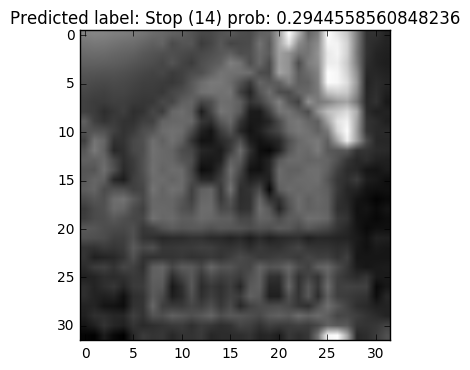

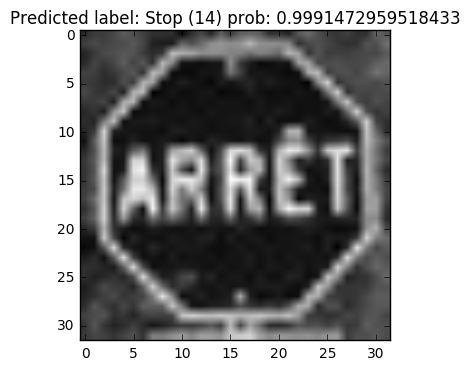

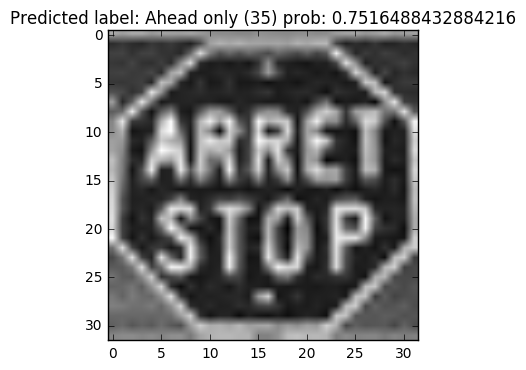

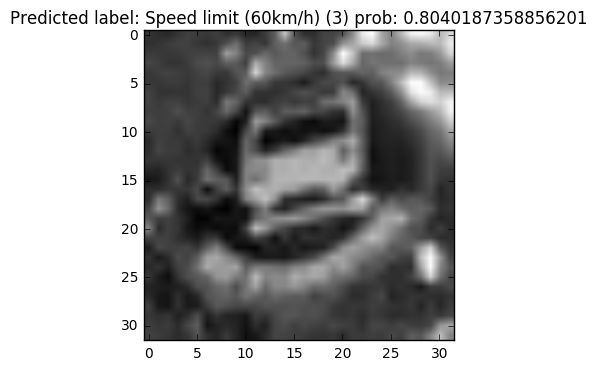

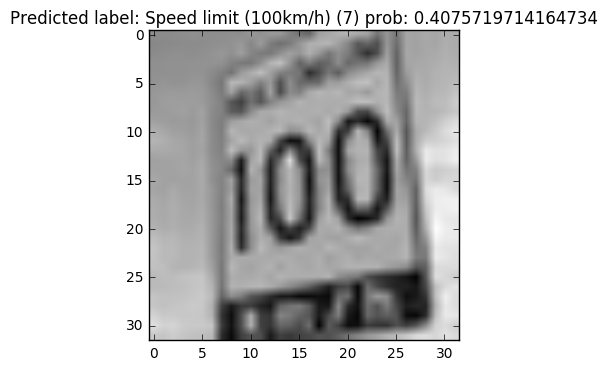

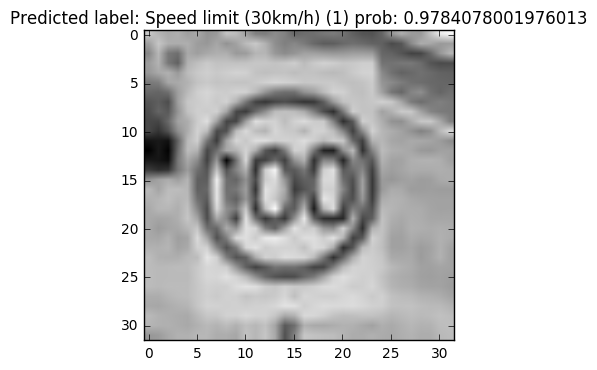

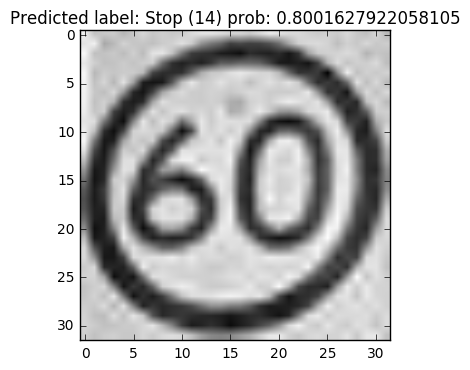

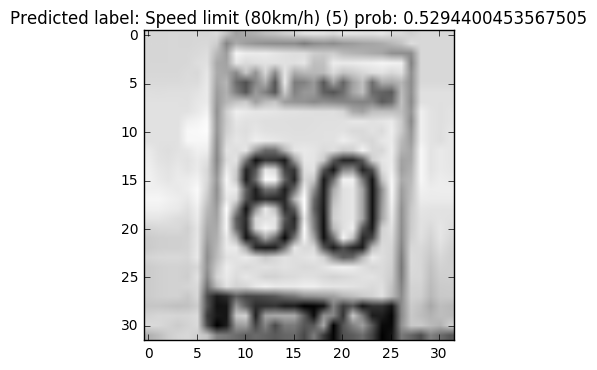

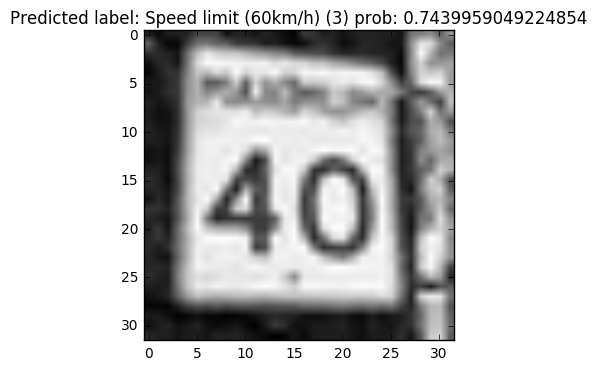

In [40]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# Run stuff here

images_to_predict = ["school.jpg", "arret.jpg", "arret_stop.jpg", "bus.jpg", 
                     "100.jpg", "100_europe.jpg", "60.jpg", "80.jpg", "40.jpg"]
for image in images_to_predict:
    predict(sess, image, top_k=False)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** The model performs poorly, as expected, on signs for which a clear analog was not included in the training set (i.e. the school crossing or the no-standing bus sign).

The model is able to classify the French stop sign with high accuracy, though it appears to be looking specifically for one word in the middle of a round-ish looking sign, as it fails to classify the stop sign with two words (Arret - stop) correctly.

The model generalizes surprisingly well to non-European stop signs, correctly classifying the 100km/h and 80km/h speed limit signs from Canada, and making a decent guess at the 40km/h sign (which actually doesn't exist in the training set). 



-----
school.jpg
-----
Rank: 1	 Logit: -0.35001	 Softmax: 0.29446	 Sign: Stop
Rank: 2	 Logit: -0.79303	 Softmax: 0.18907	 Sign: General caution
Rank: 3	 Logit: -0.91674	 Softmax: 0.16707	 Sign: Road work
Rank: 4	 Logit: -1.26743	 Softmax: 0.11765	 Sign: Bicycles crossing
Rank: 5	 Logit: -1.80686	 Softmax: 0.06860	 Sign: Wild animals crossing



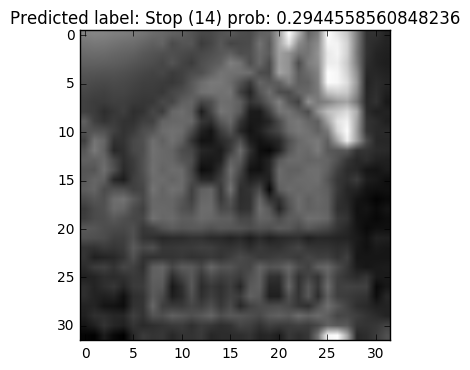

-----
arret.jpg
-----
Rank: 1	 Logit: 11.27776	 Softmax: 0.99915	 Sign: Stop
Rank: 2	 Logit: 4.15387	 Softmax: 0.00080	 Sign: Keep right
Rank: 3	 Logit: 0.39617	 Softmax: 0.00002	 Sign: Speed limit (60km/h)
Rank: 4	 Logit: -0.19034	 Softmax: 0.00001	 Sign: Turn left ahead
Rank: 5	 Logit: -0.21891	 Softmax: 0.00001	 Sign: No vechiles



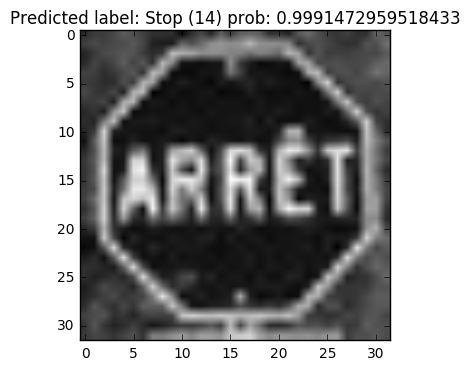

-----
arret_stop.jpg
-----
Rank: 1	 Logit: 3.19694	 Softmax: 0.75165	 Sign: Ahead only
Rank: 2	 Logit: 1.00741	 Softmax: 0.08416	 Sign: Road work
Rank: 3	 Logit: 0.98927	 Softmax: 0.08265	 Sign: Yield
Rank: 4	 Logit: -0.05796	 Softmax: 0.02900	 Sign: Turn right ahead
Rank: 5	 Logit: -0.21641	 Softmax: 0.02475	 Sign: No passing for vechiles over 3.5 metric tons



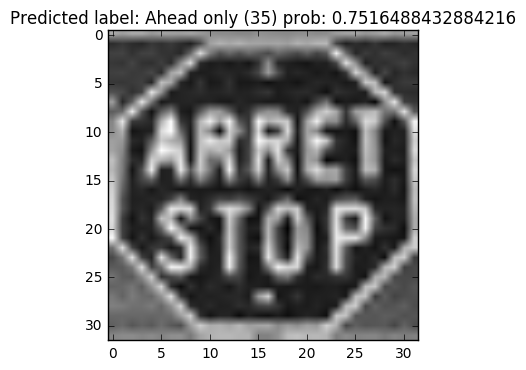

-----
bus.jpg
-----
Rank: 1	 Logit: 4.11278	 Softmax: 0.80402	 Sign: Speed limit (60km/h)
Rank: 2	 Logit: 2.31585	 Softmax: 0.13331	 Sign: Turn left ahead
Rank: 3	 Logit: 1.08298	 Softmax: 0.03885	 Sign: Speed limit (80km/h)
Rank: 4	 Logit: -0.17381	 Softmax: 0.01106	 Sign: Keep right
Rank: 5	 Logit: -0.77484	 Softmax: 0.00606	 Sign: No vechiles



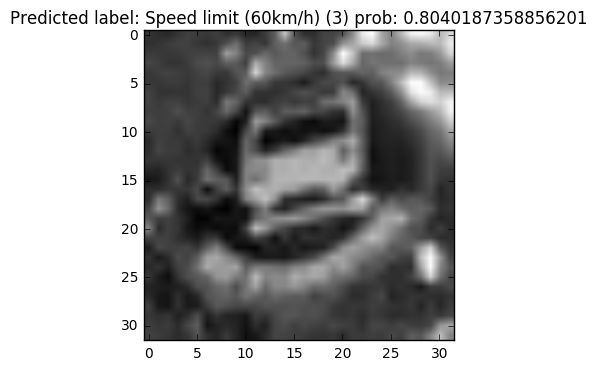

-----
100.jpg
-----
Rank: 1	 Logit: -0.80952	 Softmax: 0.40757	 Sign: Speed limit (100km/h)
Rank: 2	 Logit: -1.08041	 Softmax: 0.31086	 Sign: Speed limit (120km/h)
Rank: 3	 Logit: -2.28987	 Softmax: 0.09275	 Sign: Roundabout mandatory
Rank: 4	 Logit: -2.36886	 Softmax: 0.08570	 Sign: Speed limit (80km/h)
Rank: 5	 Logit: -3.78192	 Softmax: 0.02086	 Sign: Bicycles crossing



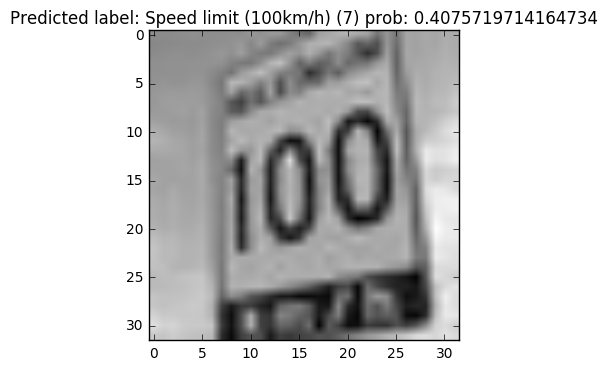

-----
100_europe.jpg
-----
Rank: 1	 Logit: 6.98064	 Softmax: 0.97841	 Sign: Speed limit (30km/h)
Rank: 2	 Logit: 2.42058	 Softmax: 0.01024	 Sign: Speed limit (80km/h)
Rank: 3	 Logit: 2.38209	 Softmax: 0.00985	 Sign: Speed limit (50km/h)
Rank: 4	 Logit: -0.00921	 Softmax: 0.00090	 Sign: Speed limit (20km/h)
Rank: 5	 Logit: -1.42312	 Softmax: 0.00022	 Sign: Speed limit (100km/h)



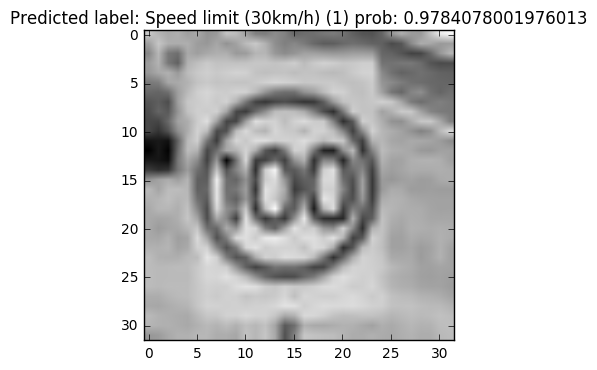

-----
60.jpg
-----
Rank: 1	 Logit: 3.52625	 Softmax: 0.80016	 Sign: Stop
Rank: 2	 Logit: 1.35189	 Softmax: 0.09096	 Sign: Speed limit (60km/h)
Rank: 3	 Logit: 1.15789	 Softmax: 0.07492	 Sign: Speed limit (50km/h)
Rank: 4	 Logit: -0.34148	 Softmax: 0.01673	 Sign: Turn left ahead
Rank: 5	 Logit: -0.99769	 Softmax: 0.00868	 Sign: Keep right



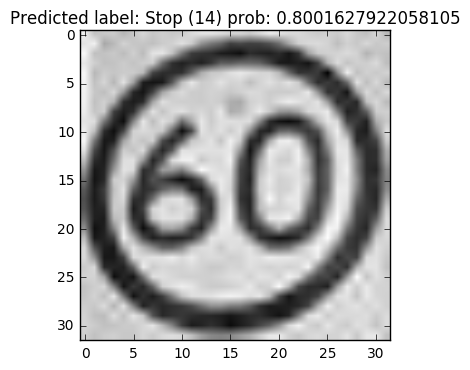

-----
80.jpg
-----
Rank: 1	 Logit: 7.24686	 Softmax: 0.52944	 Sign: Speed limit (80km/h)
Rank: 2	 Logit: 6.48062	 Softmax: 0.24606	 Sign: Speed limit (50km/h)
Rank: 3	 Logit: 6.38795	 Softmax: 0.22428	 Sign: Speed limit (60km/h)
Rank: 4	 Logit: -0.71715	 Softmax: 0.00018	 Sign: No passing for vechiles over 3.5 metric tons
Rank: 5	 Logit: -3.40128	 Softmax: 0.00001	 Sign: Speed limit (30km/h)



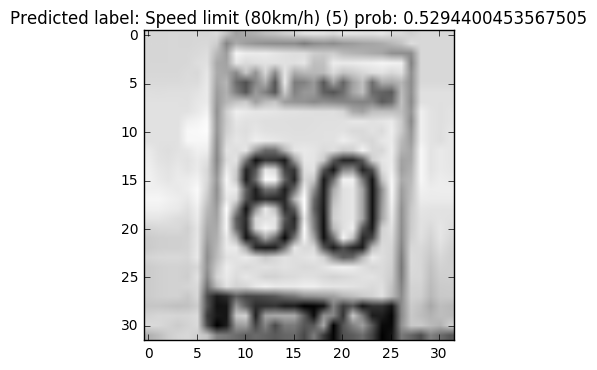

-----
40.jpg
-----
Rank: 1	 Logit: 3.20578	 Softmax: 0.74400	 Sign: Speed limit (60km/h)
Rank: 2	 Logit: 1.43739	 Softmax: 0.12693	 Sign: Road work
Rank: 3	 Logit: 1.29601	 Softmax: 0.11020	 Sign: Speed limit (50km/h)
Rank: 4	 Logit: -1.08075	 Softmax: 0.01023	 Sign: Ahead only
Rank: 5	 Logit: -1.54962	 Softmax: 0.00640	 Sign: Speed limit (80km/h)



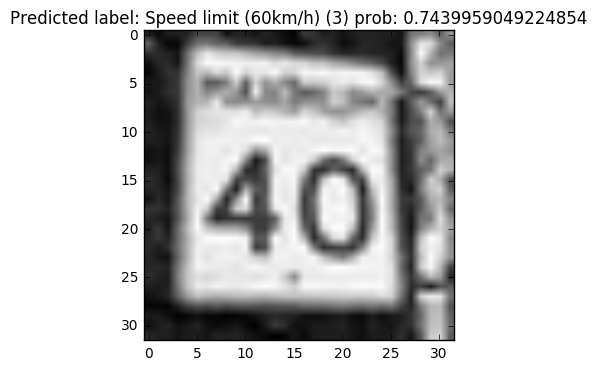

In [41]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

for image in images_to_predict:
    predict(sess, image, top_k=True)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** The model is extremely certain of its prediction on the French "ARRET" stop sign.

It is understandably less certain on the signs for which a clear analogue does not exist in the training set, such as the school crossing or the bus "no standing" sign.

For the speed limit signs, the model either predicts the correct value or shows a correct value in the top 5. The fact that the correct classification was ranked 5th for the European 100 speed limit sign is concerning, however.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** See code cell 72 above. I cropped images to 32x32 and saved as jpgs.

The images are read in as np.ndarrays using cv2.imread(). I used the rgb_to_gray helper function to convert to grayscale, the normalize function, and then feed them into the TensorFlow NN using the "y_pred" variable and feeding the image as "x" in the feed_dict.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.